# Matchup satellite data to ship, glider, or animal tracks

## Overview
> History | Updated Feb 2026 

In this exercise you will extract satellite data around a set of points defined by longitude, latitude, and time coordinates, like that produced by an animal telemetry tag, and ship track, or a glider tract.

Please note that there may be more efficient ways, more Pythonic ways, to accomplish the tasks in this tutorial. The tutorial was developed to be easier to follow for less experienced users of Python.

### The exercise demonstrates the following techniques:

* Loading data from a tab- or comma-separated file
* Plotting the latitude/longitude points onto a map 
* Extracting satellite data along a track
* Summarizing satellite values using either a single nearest pixel or a small spatial window
* Saving results as a CSV file
* Plotting the satellite data onto a map  

### Datasets used:
- Chlorophyll a concentration from the European Space Agency's Ocean Colour Climate Change Initiative Monthly dataset v6.0
- A loggerhead turtle telemetry track that has been subsample to reduce the data requests needed for this tutorial from over 1200 to 25. The turtle was raised in captivity in Japan, then tagged and released on 05/04/2005 in the Central Pacific. Its tag transmitted for over 3 years and went all the way to the Southern tip of Baja California. The track data can be downloaded from `data` folder in this project folder.
- Dusky shark telemetry detections, consisting of longitude, latitude, date, and transmitter ID information from acoustic tags deployed along the U.S. East Coast. This example demonstrates matching satellite chlorophyll using a small spatial window (±0.2°) to better represent local environmental conditions experienced by the animal.
- Chlorophyll-a, Aqua MODIS, NPP, L3SMI, Global, 4km, Science Quality, 2003-present (8 Day Composite)

### Python packages used:
- pandas (reading and analyzing data)  
- numpy  (data analysis, manipulation)
- xarray (multi-dimensional data analysis, manipulation)
- matplotlib (mapping)
- cartopy (mapping)
- datetime (date manipulation)

## Import the required Python modules

In [1]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import os
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import xarray as xr
warnings.filterwarnings('ignore')

## Load the track data into a Pandas data frame
Below, the track data will load using the Pandas "read_csv" method. 
* Then use the ".head()" method to view the column names and the first few rows of data. 


In [3]:
track_path = os.path.join('..',
                          'data',
                          '25317_05_subsampled.dat')

df = pd.read_csv(track_path)
print(df.head(2))

     mean_lon   mean_lat  year  month  day
0  176.619433  32.678728  2005      5    4
1  175.860895  35.057734  2005      6   23


## Plot the track on a map

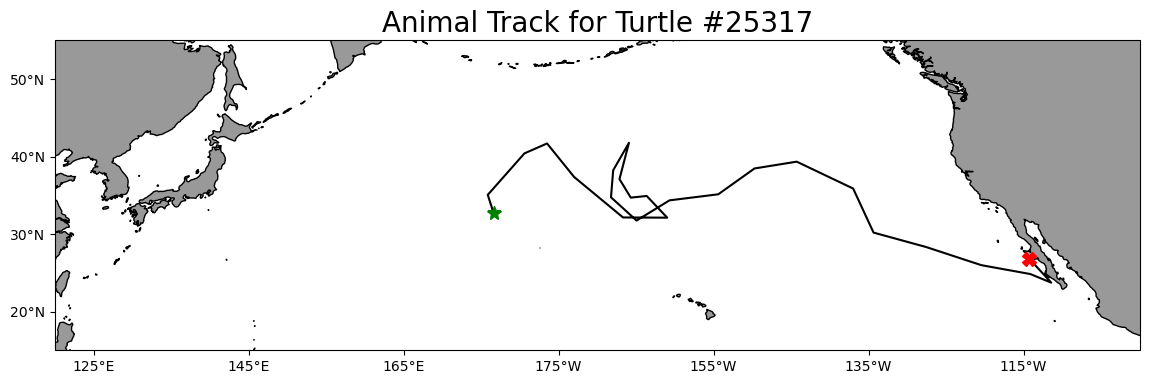

In [4]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([120, 260, 15, 55], ccrs.PlateCarree())

# Set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(125, 255, 20), crs=ccrs.PlateCarree())
ax1.set_yticks(range(20, 60, 10), crs=ccrs.PlateCarree())

# Add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# Format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Bring the lon and lat data into a numpy array 
x, y = df.mean_lon.to_numpy(), df.mean_lat.to_numpy()
ax1 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='k')
# start point in green star
ax1 = plt.plot(x[0], y[0],
               marker='*',
               color='g',
               transform=ccrs.PlateCarree(),
               markersize=10)
# end point in red X
ax1 = plt.plot(x[-1], y[-1],
               marker='X',
               color='r',
               transform=ccrs.PlateCarree(),
               markersize=10)
plt.title('Animal Track for Turtle #25317', fontsize=20)

plt.show()

## Prepare track data for use to extract satellite data

### Create a column with Pandas date objects  

__Reload the "25317_05_subsampled.dat". This time we will use the "parse_dates" option to create a Pandas date object column (year_month_day) from the 'year', 'month', and 'day' columns.__   


In [5]:
df = pd.read_csv(track_path,
                 parse_dates=[['year', 'month', 'day']]
                 )

print('The new year_month_day column contains the Pandas date objects')
print(df.head(2))
print(df.dtypes)


The new year_month_day column contains the Pandas date objects
  year_month_day    mean_lon   mean_lat
0     2005-05-04  176.619433  32.678728
1     2005-06-23  175.860895  35.057734
year_month_day    datetime64[ns]
mean_lon                 float64
mean_lat                 float64
dtype: object


## Extract data from a satellite dataset corresponding to points on the track

We are going to download data from an ERDDAP server using the following steps: 
* Select a dataset on an ERDDAP server
* Open the dataset using the Xarray module
* Loop though the track data and pull out the date, latitude and longitude coordinates from each row 
* Insert these coordinates into the Xarray open-dataset object to select and download the satellite data that corresponds to the coordinates. 
* Store the satellite data in a temporary Pandas data frame
* Once all the satellite data has been added to the temporary data frame, merge it with the track data frame.

### Select a dataset

We'll use the European Space Agency's OC-CCI product (https://climate.esa.int/en/projects/ocean-colour/) to obtain chlorophyll data. This is a merged product that blends data from many ocean color sensors to create a long time series (1997-present) with better spatial coverage than any single sensor.


Ideally we would use a daily dataset, selecting the day that corresponds to the track data date. However, chlorophyll measurements can have a lot of missing data, primarily due to cloud cover. To reduce data gaps and improve the likelihood of data for our matchups, we can use a dataset that combines all of the data from each month into the monthly average. 

__The ERDDAP URL to the monthly version of the OC-CCI product is below:__    
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0  
 


###  Open the satellite data in Xarray
* Use the ERDDAP URL with no extension (e.g. without .html or .graph...). This is the OPeNDAP URL, which allows viewing  the dataset metadata and, when you select the data you want, downloading the data.
* Use the Xarray "open_dataset" function then view the metadata

In [6]:
erddap_url = '/'.join(['https://oceanwatch.pifsc.noaa.gov',
                       'erddap',
                       'griddap',
                       'esa-cci-chla-monthly-v6-0'])

ds = xr.open_dataset(erddap_url)
ds

<xarray.Dataset> Size: 472GB
Dimensions:             (time: 316, latitude: 4320, longitude: 8640)
Coordinates:
  * time                (time) datetime64[ns] 3kB 1997-09-04 ... 2023-12-01
  * latitude            (latitude) float64 35kB 89.98 89.94 ... -89.94 -89.98
  * longitude           (longitude) float64 69kB 0.02083 0.0625 ... 359.9 360.0
Data variables:
    chlor_a             (time, latitude, longitude) float32 47GB ...
    MERIS_nobs_sum      (time, latitude, longitude) float32 47GB ...
    MODISA_nobs_sum     (time, latitude, longitude) float32 47GB ...
    OLCI_A_nobs_sum     (time, latitude, longitude) float32 47GB ...
    OLCI_B_nobs_sum     (time, latitude, longitude) float32 47GB ...
    SeaWiFS_nobs_sum    (time, latitude, longitude) float32 47GB ...
    VIIRS_nobs_sum      (time, latitude, longitude) float32 47GB ...
    chlor_a_log10_bias  (time, latitude, longitude) float32 47GB ...
    chlor_a_log10_rmsd  (time, latitude, longitude) float32 47GB ...
    total_nobs_sum      (time, latitude, longitude) float32 47GB ...
Attributes: (12/53)
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    Conventions:                       CF-1.7, COARDS, ACDD-1.3
    creation_date:                     Thu Jan 18 09:04:18 2024
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    ...                                ...
    time_coverage_end:                 2023-12-01T00:00:00Z
    time_coverage_resolution:          P1M
    time_coverage_start:               1997-09-04T00:00:00Z
    title:                             Chlorophyll a concentration, ESA OC CC...
    tracking_id:                       abd52a4c-7009-464f-b1eb-958f7d333a1d
    Westernmost_Easting:               0.020833333333314386

__Opening the dataset in Xarray lets you look at the dataset metadata.__   
* The metadata are listed above.
* No data is downloaded until you request it.  

__From the metadata you can view:__ 
* The coordinates (time, latitude and longitude) that you will use to select the data to download.
* A list of ten data variables. For this exercise, we want the "chlor_a" variable. If you want, you can find out about each variable with clicking the page icon to the right of each variable name. 


__A note on dataset selection__  
We have preselected the OC-CCI monthly dataset because we know it will work with this exercise. If you were selecting datasets on your own, you would want to check out the dataset to determine if its spatial and temporal coverages are suitable for your application. 

You can find that information above by clicking the right arrow next to "Attribute". Then look through the list to find: 
* 'time_coverage_start' and 'time_coverage_end': the time range
* 'geospatial_lat_min' and 'geospatial_lat_max': the latitude range
* 'geospatial_lon_min' and 'geospatial_lon_max': the longitude range

There are a lot of metadata attributes to look through. We can make it easier with a little code to print out the metadata of interest. Then compare these ranges to those found in your track data.


In [7]:
print('Temporal and spatial ranges of the satellite dataset')
print('time range', ds.attrs['time_coverage_start'], 
      ds.attrs['time_coverage_end'])
print('latitude range', ds.attrs['geospatial_lat_min'], 
      ds.attrs['geospatial_lat_max'])
print('longitude range', ds.attrs['geospatial_lon_min'], 
      ds.attrs['geospatial_lon_max'])
print(' ')
print('Temporal and spatial ranges of the track data')
print('time range', df.year_month_day.min(), df.year_month_day.max())
print('latitude range', 
      round(df.mean_lat.min(), 2), round(df.mean_lat.max(), 2))
print('longitude range', 
      round(df.mean_lon.min(), 2), round(df.mean_lon.max(), 2))

Temporal and spatial ranges of the satellite dataset
time range 1997-09-04T00:00:00Z 2023-12-01T00:00:00Z
latitude range -89.97916666666666 89.97916666666667
longitude range 0.020833333333314386 359.97916666666663
 
Temporal and spatial ranges of the track data
time range 2005-05-04 00:00:00 2008-08-16 00:00:00
latitude range 23.72 41.77
longitude range 175.86 248.57


### Download the satellite data that corresponds to each track location

In [8]:
# Create a temporary Pandas data frame to hold the downloaded satellite data
col_names = ["erddap_date", "matched_lat", "matched_lon", "matched_chla"]
tot = pd.DataFrame(columns=col_names)

# Finish each URL and download
for i in range(0, len(df)):
    clear_output(wait=True)
    print(i+1, 'of', len(df))
    
    # Crop the dataset to include data that corresponds to track locations
    cropped_ds = ds['chlor_a'].sel(time=df.year_month_day[i],
                                   latitude=df.mean_lat[i],
                                   longitude=df.mean_lon[i],
                                   method='nearest'
                                   )
     
    # Downloaded the data and add it to a new line in the tot data frame
    tot.loc[len(tot.index)] = [cropped_ds.time.values,
                               np.round(cropped_ds.latitude.values, 5),  # round 5 dec
                               np.round(cropped_ds.longitude.values, 5), # round 5 dec
                               np.round(cropped_ds.values, 2)  # round 2 decimals
                               ]
    
    print(tot.loc[[len(tot)-1]])

tot.head(2)

25 of 25
   erddap_date  matched_lat  matched_lon  matched_chla
24  2008-08-01     26.77083    245.77083          0.71


,erddap_date,matched_lat,matched_lon,matched_chla
0,2005-05-01,32.6875,176.60417,0.29
1,2005-07-01,35.0625,175.85417,0.11


### Consolidate the downloaded satellite data into the track data frame

In [9]:

df[['matched_lat', 
    'matched_lon', 
    'matched_chla', 
    'erddap_date']] = tot[['matched_lat',
                           'matched_lon',
                           'matched_chla',
                           'erddap_date']]

df.head(2)

,year_month_day,mean_lon,mean_lat,matched_lat,matched_lon,matched_chla,erddap_date
0,2005-05-04,176.619433,32.678728,32.6875,176.60417,0.29,2005-05-01
1,2005-06-23,175.860895,35.057734,35.0625,175.85417,0.11,2005-07-01


### Save your work

In [10]:
df.to_csv('chl_matchup_turtle25327.csv', index=False, encoding='utf-8')

## Plot chlorophyll matchup data onto a map

### First plot a histogram of the chlorophyll data

Range: 0.06 0.71


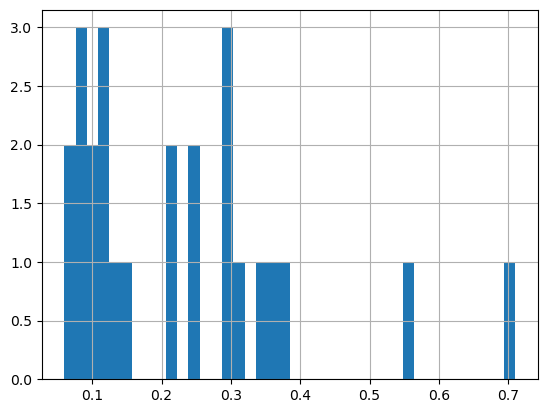

In [11]:
print('Range:', df.matched_chla.min(), df.matched_chla.max())
_ = df.matched_chla.hist(bins=40)

The range of chlorophyll values can be large, with lots of very low values and a few very high values. Using a  linear color bar,  most of the lower values would have the same color.
* To better visualize the data, we often plot the log or log10 of chlorophyll. 

### Plot a histogram of the log of the chlorophyll data

Range: -2.8134108 -0.34249032


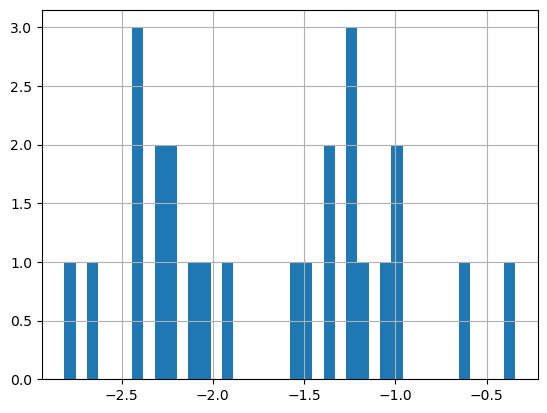

In [12]:
print('Range:', np.log(df.matched_chla.min()), np.log(df.matched_chla.max()))
_ = np.log(df.matched_chla).hist(bins=40)

* The logarithmic transformation displays the range of values across the color bar range (above). 

### Map the chlorophyll data

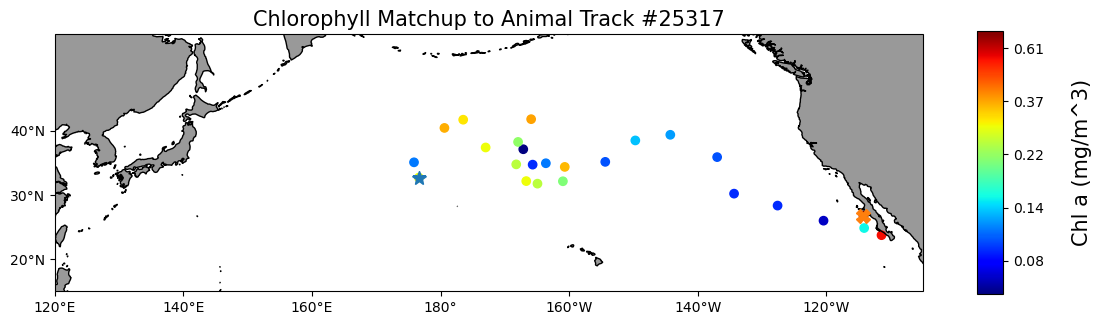

In [13]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:

# set the projection
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([120,255, 15, 55], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(120,255,20), crs=ccrs.PlateCarree())
ax1.set_yticks(range(20,50,10), crs=ccrs.PlateCarree())

# Add geographical features
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# build and plot coordinates onto map
x,y = list(df.mean_lon),list(df.mean_lat)
ax1 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  c=np.log(df.matched_chla),
                  cmap=plt.get_cmap('jet')
                  )
ax1=plt.plot(x[0],y[0],marker='*', transform=ccrs.PlateCarree(), markersize=10)
ax1=plt.plot(x[-1],y[-1],marker='X', transform=ccrs.PlateCarree(), markersize=10)



# control color bar values spacing
levs2 = np.arange(-2.5, 0, 0.5)
cbar=plt.colorbar(ticks=levs2, shrink=0.75, aspect=10)
cbar.set_label("Chl a (mg/m^3)", size=15, labelpad=20)

# set the labels to be exp(levs2) so the label reflect values of chl-a, not log(chl-a)
cbar.ax.set_yticklabels(np.around(np.exp(levs2), 2), size=10)

plt.title("Chlorophyll Matchup to Animal Track #25317", size=15)
plt.show()

## On your own!

##### Exercise 1:
Repeat the steps above with a different dataset.
For example, extract sea surface temperature data using the NOAA Geo-polar Blended Analysis SST, GHRSST dataset:
https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5NRT_Lon0360.html  
* This dataset is a different ERDDAP; It has a different base URL and dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset.   


##### Exercise 2:
Go to an ERDDAP of your choice, find a dataset of interest, generate the URL, copy it and edit the script above to run a match up on that dataset.
To find other ERDDAP servers, you can use this search engine:
http://erddap.com/  
* This dataset will likely be on a different base URL and dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset. 

##### Optional
Repeat the steps above with a daily version of the OC-CCI dataset to see how cloud cover can reduce the data you retrieve. 
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0.html


# Match satellite chlorophyll to Dusky shark telemetry

The turtle example above selects a single nearest satellite pixel at each track point. In many real-world applications, it can be useful to match a small neighborhood of pixels around each location and summarize the satellite values (e.g. mean chlorophyll with ±0.2°). This helps reduce noise from single-pixel values and can better represent local conditions.

In this example, we:

- Load dusky shark tag detections (lon, lat, date)
- Open a gridded chlorophyll dataset using Xarray (OPenDAP)
- For each detection:
  - select the nearest satellite time
  - extract ±0.2° window in lon/lat
  - compute mean, standard deviation, and valid pixel count

**Data note:** These dusky shark data were collected and provided by Dr. Chuck Bangley (Smithsonian Environmental Research Center). For details, see:

    Bangley, C.W., et al. (2020) Identifying Important Juvenile Dusky Shark Habitat in the Northwest Atlantic Ocean Using Acoustic Telemetry and Spatial Modeling. Marine and Coastal Fisheries, 12:348–363. DOI: 10.1002/mcf2.10120


## Load Dusky shark telemetry data
Load the dusky shark acoustic telemetry detections, which include longitude, latitude, detection date, and transmitter ID. Each row represents a single shark detection that will be matched to satellite data.


In [ ]:
# Load shark tag data (lon, lat, date, transmitter ID)
tag_path = os.path.join('..',
                          'resources',
                          'DuskyDaily_NOAAclass_sortedTransmitterDate.csv')

tags = pd.read_csv(tag_path)

print(tags.head(3))


      Transmitter       Date  Latitude  Longitude  Unnamed: 4  \
0  A69-1601-46065  9/15/2017  38.22503  -75.03418         NaN   
1  A69-1601-46065  9/27/2017  38.30890  -75.01166         NaN   
2  A69-1601-46065  10/2/2017  38.30890  -75.01166         NaN   

  Unique Transmitters  
0      A69-9006-16095  
1      A69-9001-16950  
2      A69-9006-16094  


## Convert telemetry columns to coordinate arrays

Longitude, latitude, and detection dates are extracted and converted into NumPy arrays and datetime objects. This format is required for iterating over detections and selecting satellite data by time.


In [3]:
# Convert columns to arrays (same pattern used earlier in this tutorial)
xcoord = tags["Longitude"].to_numpy()
ycoord = tags["Latitude"].to_numpy()
tcoord = pd.to_datetime(tags["Date"], format="%m/%d/%Y").to_numpy()

## Open a satellite dataset using Xarray (OPeNDAP)
For this example, we use a CoastWatch MODIS 8-day chlorophyll dataset

In [5]:
erddap_url2 = '/'.join(['https://coastwatch.pfeg.noaa.gov/',
                       'erddap',
                       'griddap',
                       'erdMH1chla8day'])

ds_shark = xr.open_dataset(erddap_url2)
ds_shark

print("Temporal and spatial ranges of the satellite dataset")
print("time range", ds_shark.attrs["time_coverage_start"], ds_shark.attrs["time_coverage_end"])
print("latitude range", ds_shark.attrs["geospatial_lat_min"], ds_shark.attrs["geospatial_lat_max"])
print("longitude range", ds_shark.attrs["geospatial_lon_min"], ds_shark.attrs["geospatial_lon_max"])

Temporal and spatial ranges of the satellite dataset
time range 2003-01-05T00:00:00Z 2022-06-14T00:00:00Z
latitude range -89.97917 89.97916
longitude range -179.9792 179.9792


## Match each shark detection to a local satellite window (±0.2°)
This function matches a single shark detection to satellite chlorophyll by selecting the nearest satellite time and extracting a ±0.2° spatial window. It summarizes local conditions by computing the mean, standard deviation, and number of valid pixels.


In [ ]:
def match_one_point(ds, lon, lat, req_time, half_window=0.2):
    """
    Match a single telemetry detection to satellite chlorophyll using
    spatial averaging within a local window.

    For a given longitude, latitude, and detection time, this function:
    selects the nearest satellite time, extracts chlorophyll pixels within
    a ±half_window degree box around the detection, and summarizes local
    conditions using the mean, standard deviation, and number of valid pixels.

    Parameters
    ----------
    ds : xarray.Dataset
        ERDDAP gridded satellite dataset opened via Xarray/OPeNDAP.
    lon : float
        Longitude of the telemetry detection (decimal degrees).
    lat : float
        Latitude of the telemetry detection (decimal degrees).
    req_time : datetime-like
        Telemetry detection time; the nearest satellite time is used.
    half_window : float, optional
        Half-width of the spatial averaging window in degrees (default 0.2).

    Returns
    -------
    dict
        Dictionary containing mean chlorophyll, standard deviation, number
        of valid pixels, the matched satellite time, spatial window bounds,
        and the original detection time.
    """
    # Nearest satellite time
    ds_time = ds.sel(time=req_time, method="nearest")
    sat_time = pd.to_datetime(ds_time.time.values)

    # Spatial bounds
    lon_min = lon - half_window
    lon_max = lon + half_window
    lat_min = lat - half_window
    lat_max = lat + half_window

    # Latitude often runs descending in ERDDAP products
    chl = ds_time["chlorophyll"].sel(
        longitude=slice(lon_min, lon_max),
        latitude=slice(lat_max, lat_min)
    )

    return {
        "mean_chlorophyll": float(chl.mean(skipna=True)),
        "stdev_chlorophyll": float(chl.std(skipna=True)),
        "n": int(chl.count()),
        "satellite_date": sat_time,
        "requested_lon_min": lon_min,
        "requested_lon_max": lon_max,
        "requested_lat_min": lat_min,
        "requested_lat_max": lat_max,
        "requested_date": pd.to_datetime(req_time),
    }


## Run the matchup for all shark detections



In [8]:
# Run the matchup for every point:
half_window = 0.2

rows = [
    match_one_point(ds_shark, lon, lat, t, half_window=half_window)
    for lon, lat, t in zip(xcoord, ycoord, tcoord)
]

shark_matchups = pd.DataFrame.from_records(rows)
shark_matchups.head()

,mean_chlorophyll,stdev_chlorophyll,n,satellite_date,requested_lon_min,requested_lon_max,requested_lat_min,requested_lat_max,requested_date
0,3.600632,1.796631,62,2017-09-18,-75.234180,-74.834180,38.025030,38.425030,2017-09-15
1,3.486308,1.330631,62,2017-09-26,-75.211660,-74.811660,38.108900,38.508900,2017-09-27
2,5.782278,3.086404,67,2017-10-04,-75.211660,-74.811660,38.108900,38.508900,2017-10-02
3,1.374190,0.879763,16,2017-10-12,-74.976897,-74.576897,38.474039,38.874039,2017-10-08
4,0.864735,0.149003,24,2017-10-12,-74.860156,-74.460156,38.324397,38.724397,2017-10-09


## Assemble a consolidated telemetry–satellite dataset

Telemetry coordinates, transmitter IDs, and matched chlorophyll values are combined into a single DataFrame. This unified table is used for all subsequent mapping and analysis steps.


In [9]:
alltags = pd.DataFrame({
    "lon": xcoord,
    "lat": ycoord,
    "chlorophyll": shark_matchups["mean_chlorophyll"].to_numpy(),
    "transmitter": tags["Transmitter"].to_numpy(),
    "date": shark_matchups["requested_date"].to_numpy(),
})

print(alltags.shape)
alltags.head()

(417, 5)


,lon,lat,chlorophyll,transmitter,date
0,-75.034180,38.225030,3.600632,A69-1601-46065,2017-09-15
1,-75.011660,38.308900,3.486308,A69-1601-46065,2017-09-27
2,-75.011660,38.308900,5.782278,A69-1601-46065,2017-10-02
3,-74.776897,38.674039,1.374190,A69-1601-46065,2017-10-08
4,-74.660156,38.524397,0.864735,A69-1601-46065,2017-10-09


## Map of all sharks colored by chlorophyll
Plot the locations of all tagged dusky sharks and color each detection by the mean satellite-derived chlorophyll-a concentration matched to that location and date.

Each point represents a single shark detection, and the color scale highlights spatial differences in chlorophyll conditions encountered by sharks across the study area. A simple land mask and coastline provide geographic context, while latitude and longitude gridlines help orient the map.

This visualization provides a spatial overview of shark movements in relation to surface ocean productivity.

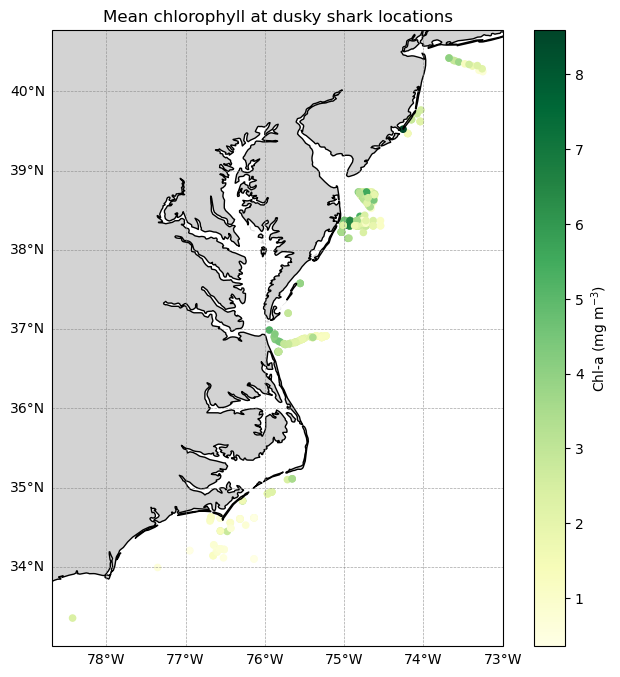

In [10]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE)

sc = ax.scatter(
    alltags["lon"],
    alltags["lat"],
    c=alltags["chlorophyll"],
    cmap="YlGn",
    s=20,
    transform=ccrs.PlateCarree()
)

plt.colorbar(sc, label="Chl-a (mg m$^{-3}$)")

gl = ax.gridlines(
    draw_labels=True,
    linewidth=0.5,
    color="gray",
    alpha=0.7,
    linestyle="--"
)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title("Mean chlorophyll at dusky shark locations")
plt.show()

## Subset all tags for a single shark

This step selects all detections associated with one transmitter ID. Focusing on a single shark allows individual movement patterns and environmental conditions to be examined.


In [11]:
shark1 = alltags["transmitter"].iloc[0]
print("Selected shark transmitter:", shark1)

single_shark = alltags.loc[alltags["transmitter"] == shark1, ["lon", "lat", "chlorophyll"]].copy()
single_shark.columns = ["x_shark", "y_shark", "dataval_shark"]

single_shark.head()

Selected shark transmitter: A69-1601-46065


,x_shark,y_shark,dataval_shark
0,-75.034180,38.225030,3.600632
1,-75.011660,38.308900,3.486308
2,-75.011660,38.308900,5.782278
3,-74.776897,38.674039,1.374190
4,-74.660156,38.524397,0.864735


## Plot the movement track for a single shark

Successive detections for one shark are connected with track lines and colored by chlorophyll concentration. This combined view highlights both movement pathways and changing environmental conditions along the track.


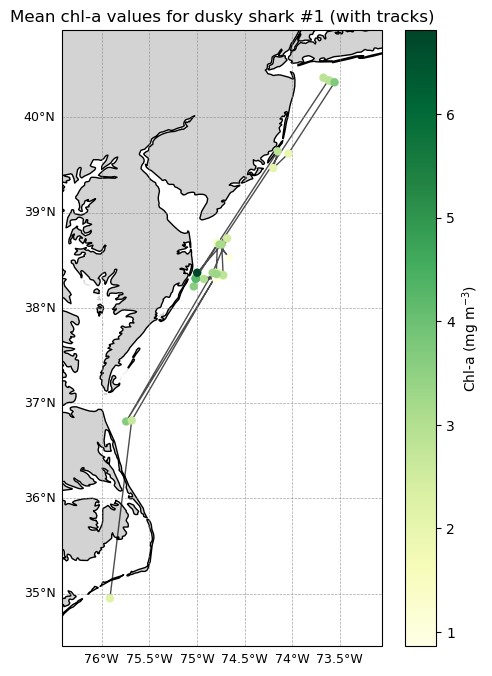

In [12]:
x = single_shark["x_shark"].to_numpy()
y = single_shark["y_shark"].to_numpy()
chl = single_shark["dataval_shark"].to_numpy()

pad = 0.5
maplonmin = x.min() - pad
maplonmax = x.max() + pad
maplatmin = y.min() - pad
maplatmax = y.max() + pad

fig = plt.figure(figsize=(6, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="lightgrey")
ax.add_feature(cfeature.COASTLINE)

ax.set_extent([maplonmin, maplonmax, maplatmin, maplatmax], crs=ccrs.PlateCarree())

# Track polyline
ax.plot(
    x, y,
    color="black",
    linewidth=1,
    alpha=0.7,
    transform=ccrs.PlateCarree()
)

# Scatter points
sc = ax.scatter(
    x, y,
    c=chl,
    cmap="YlGn",
    s=25,
    transform=ccrs.PlateCarree(),
    zorder=3
)

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.7, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 9}
gl.ylabel_style = {"size": 9}

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Chl-a (mg m$^{-3}$)")

ax.set_title("Mean chl-a values for dusky shark #1 (with tracks)")

plt.show()
plt.close(fig)

## Compare chlorophyll conditions by year using a boxplot

Matched chlorophyll values for a single shark are grouped by calendar year and displayed as a boxplot. The boxplot summarizes interannual differences and variability in environmental conditions experienced by the shark.

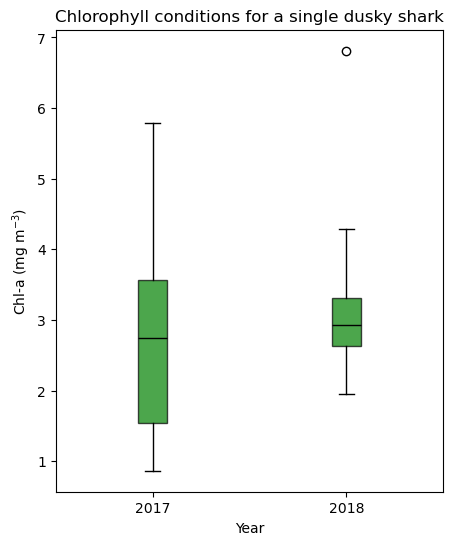

In [13]:
df1 = alltags.loc[alltags["transmitter"] == shark1, ["date", "chlorophyll"]].dropna()
df1["year"] = pd.to_datetime(df1["date"]).dt.year

vals_2017 = df1.loc[df1["year"] == 2017, "chlorophyll"].to_numpy()
vals_2018 = df1.loc[df1["year"] == 2018, "chlorophyll"].to_numpy()

fig, ax = plt.subplots(figsize=(5, 6))

ax.boxplot(
    [vals_2017, vals_2018],
    positions=[1, 2],
    patch_artist=True,                      # allow filled boxes
    boxprops=dict(facecolor="green", alpha=0.7),
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black")
)

ax.set_title("Chlorophyll conditions for a single dusky shark")
ax.set_xlabel("Year")
ax.set_ylabel("Chl-a (mg m$^{-3}$)")

ax.set_xticks([1, 2])
ax.set_xticklabels(["2017", "2018"])

plt.show()
